In [3]:
# Import modules and methods we need
import json, random, sys
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks
from PIL import Image, ImageDraw 



In [4]:
# Data format process
f = open("/Users/apple/Desktop/ships-in-satellite-imagery/shipsnet.json")
dataset = json.load(f)
f.close()
input_images = np.array(dataset['data']).astype('uint8')
output_labels = np.array(dataset['labels']).astype('uint8')
print(input_images.shape)
print(output_labels.shape)
print(output_labels)
print(np.bincount(output_labels))
n_spectrum = 3 # color chanel 
width = 80 # images size
height = 80 # images size
input_images_reshaped = input_images.reshape(-1, n_spectrum, width, height)
print(input_images_reshaped.shape)

(2800, 19200)
(2800,)
[1 1 1 ... 0 0 0]
[2100  700]
(2800, 3, 80, 80)


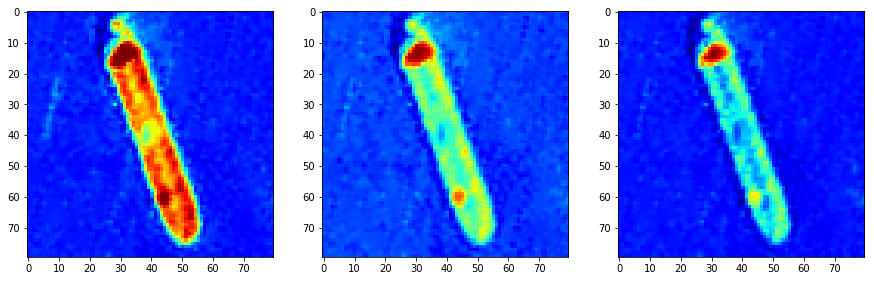

In [5]:
#show picture examples
pic = input_images_reshaped[0]
red_spectrum = pic[0]
green_spectrum = pic[1]
blue_spectum = pic[2]

plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')
# show each channel
plt.subplot(1, 3, 1)
plt.imshow(red_spectrum)
plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)
plt.subplot(1, 3, 3)
plt.imshow(blue_spectum)    
plt.show()

In [ ]:
#preparing data
y = np_utils.to_categorical(output_labels, 2) # one-hot encoding
print(y)
indexes = np.arange(2800) # shuffle indexes
np.random.shuffle(indexes)
print(indexes)
X_train = input_images_reshaped[indexes].transpose([0,2,3,1])
y_train = y[indexes]
print(X_train.shape)
X_train = X_train / 255 # normalization


In [ ]:
# Traing network
np.random.seed(42)

# network design
model = Sequential()
# 1st-layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu') )
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))
# 2nd-layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))
# 3rd-layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))
# 4th-layer
model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))
# full-connected layer
model.add(Flatten())
# hidden neurons addition
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# Output layer
model.add(Dense(2, activation='softmax'))

# optimizer
sgd = SGD(lr=0.01, decay=0.0, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer = sgd,
    metrics=['accuracy'])
# Training
model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)


In [ ]:
# Using network
image = Image.open('/Users/apple/Desktop/ships-in-satellite-imagery/SFO Bay Test/sfbay_1.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
#create vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)

plt.figure(1, figsize = (15, 30))
plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)
plt.show()

picture_tensor = picture_tensor.transpose(2,0,1)

In [ ]:
# Search
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}'.format(x, y))
    return area_study

def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1
                
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()
            

In [ ]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

plt.figure(1, figsize = (15, 30))
plt.subplot(3,1,1)
plt.imshow(picture_tensor)
plt.show()